In [1]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the path to your project folder
project_path = '/content/drive/MyDrive/Predictive_Maintenance_Project'

# 3. Change the current directory to your project folder
os.chdir(project_path)

# Verify you are in the right place
print("Current Working Directory:", os.getcwd())

Mounted at /content/drive
Current Working Directory: /content/drive/MyDrive/Predictive_Maintenance_Project


In [2]:
import pandas as pd
import numpy as np
import os
import zipfile
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt

data_dir = 'data'

# 3. Load Training Data (FD001)
index_names = ['unit_number', 'time_in_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv(os.path.join(data_dir, 'train_FD001.txt'), sep=r'\s+', header=None, names=col_names)
print(f"Data Loaded. Shape: {train_df.shape}")

Data Loaded. Shape: (20631, 26)


In [3]:
# Task 1.2
# 1. Recalculate raw RUL (No clipping)
# (Assuming you still have the train_df from the previous step)

# Re-calculate max_cycle just to be safe
max_cycle = train_df.groupby('unit_number')['time_in_cycles'].transform('max')
print(max_cycle.head(10))
train_df['RUL'] = max_cycle - train_df['time_in_cycles']

# The Magic Step: Clip at 125
train_df['RUL'] = train_df['RUL'].clip(upper=125)

# 2. Verify there is no clipping
print(f"Maximum RUL in dataset: {train_df['RUL'].max()}")
print("Sample of raw RUL values:")
print(train_df[['unit_number', 'time_in_cycles', 'RUL']].head(10))

0    192
1    192
2    192
3    192
4    192
5    192
6    192
7    192
8    192
9    192
Name: time_in_cycles, dtype: int64
Maximum RUL in dataset: 125
Sample of raw RUL values:
   unit_number  time_in_cycles  RUL
0            1               1  125
1            1               2  125
2            1               3  125
3            1               4  125
4            1               5  125
5            1               6  125
6            1               7  125
7            1               8  125
8            1               9  125
9            1              10  125


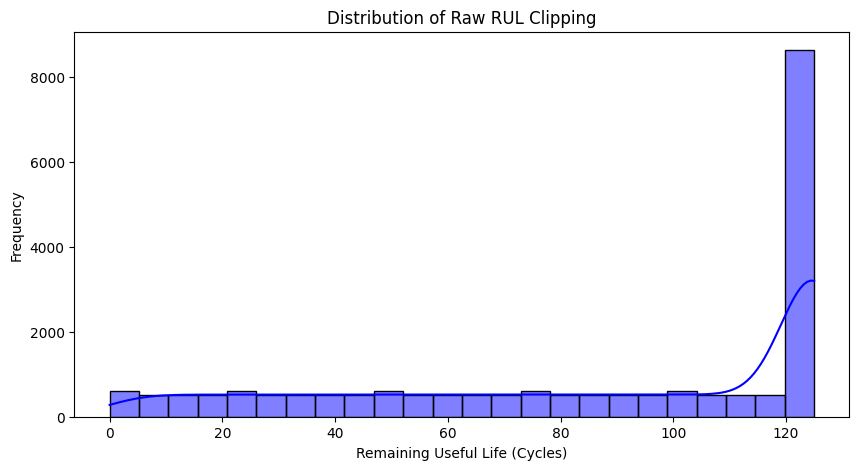

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.makedirs('reports/figures', exist_ok=True)

plt.figure(figsize=(10, 5))
sns.histplot(train_df['RUL'], kde=True, color='blue')
plt.title('Distribution of Raw RUL Clipping')
plt.xlabel('Remaining Useful Life (Cycles)')
plt.ylabel('Frequency')
plt.show()
plt.savefig('reports/figures/rul_distribution.png')
plt.close()

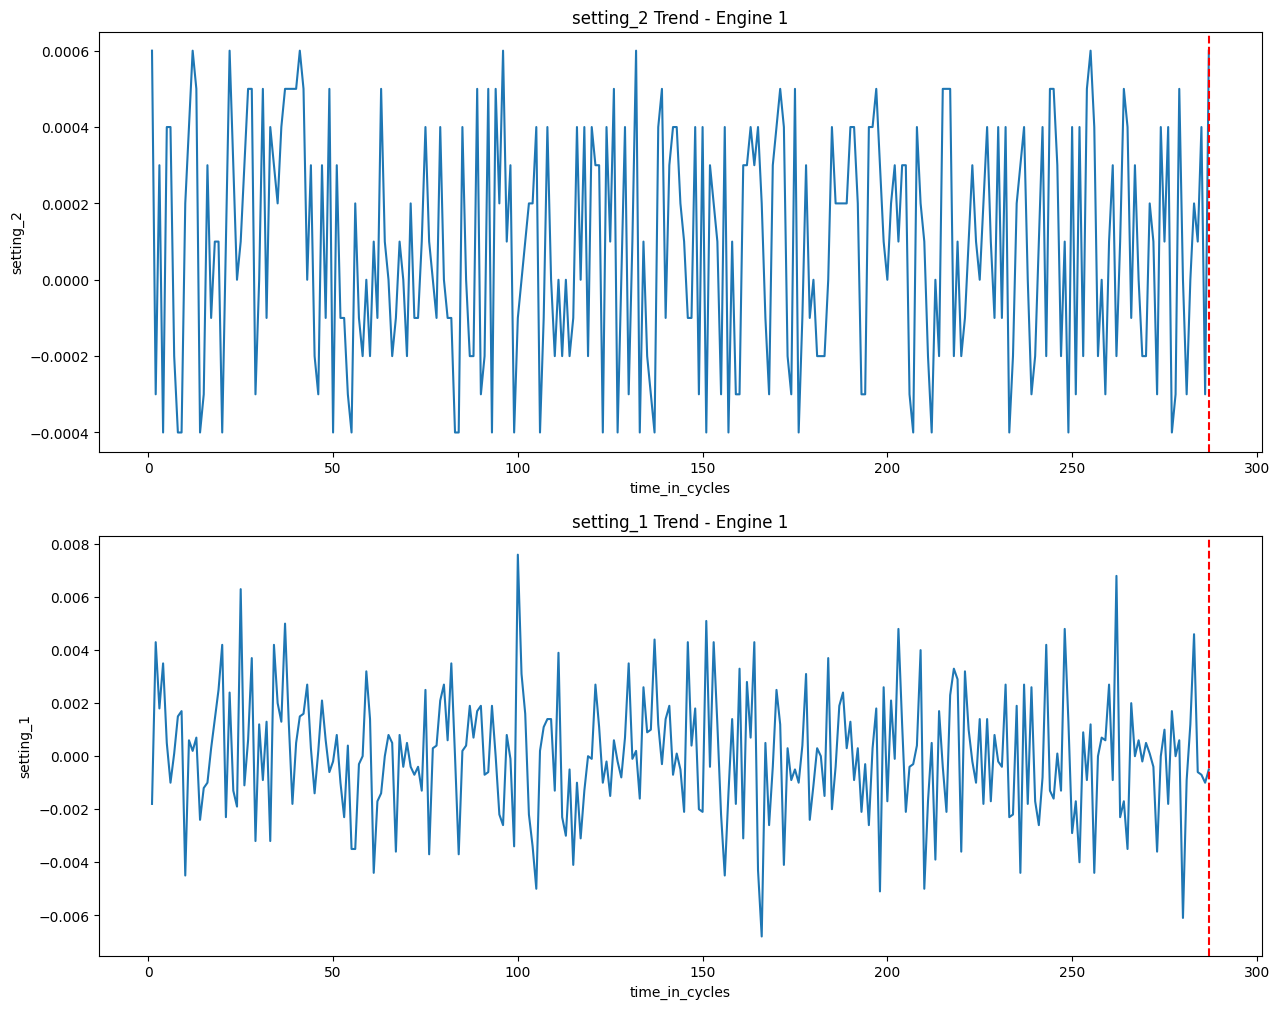

In [15]:
# Pick a variety of sensors:
# Some that trend up, some that trend down, and some that are flat.
sensors_to_plot = ['setting_2', 'setting_1']
engine_1 = train_df[train_df['unit_number'] == 2]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
axes = axes.flatten()

for i, sensor in enumerate(sensors_to_plot):
    sns.lineplot(ax=axes[i], x=engine_1['time_in_cycles'], y=engine_1[sensor])
    axes[i].set_title(f'{sensor} Trend - Engine 1')
    # Draw a vertical line where the engine actually fails
    axes[i].axvline(x=engine_1['time_in_cycles'].max(), color='red', linestyle='--')

# plt.tight_layout()
plt.show()
# plt.savefig('reports/figures/correlation_among_some_features.png')
# plt.close()
plt.savefig('reports/figures/low_correlated_features.png')
plt.close()

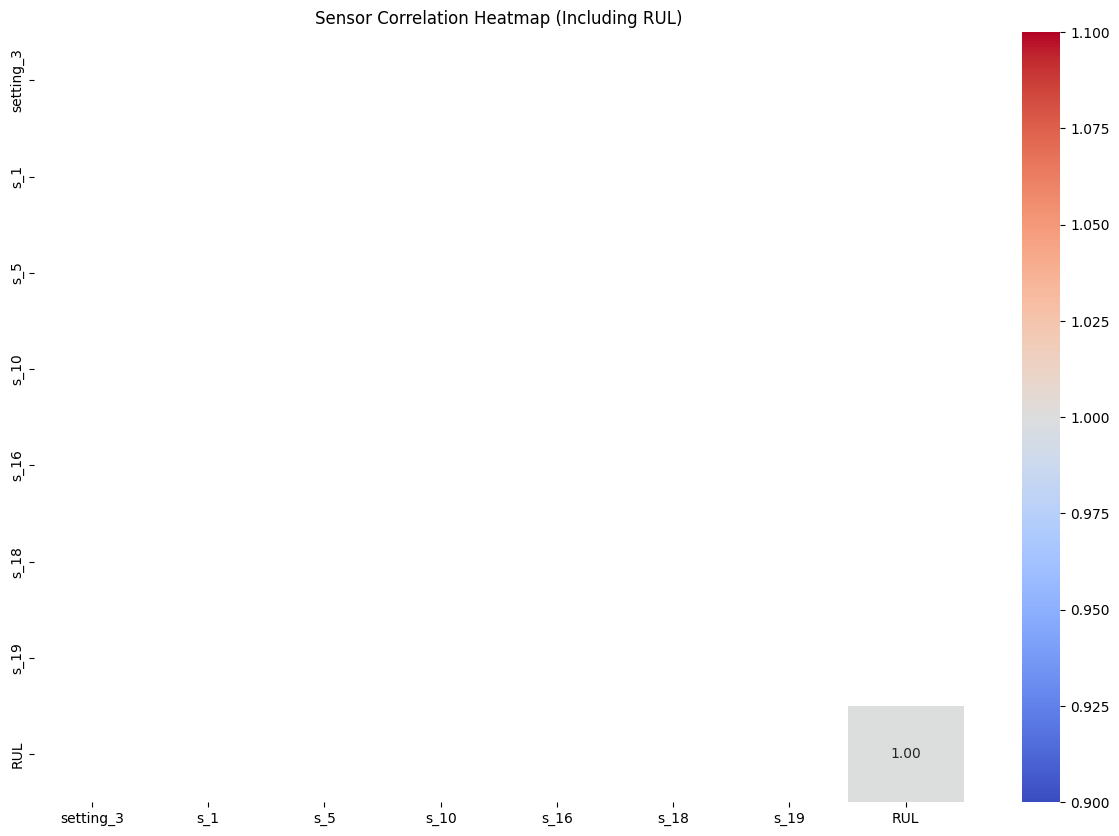

In [8]:
sequence_cols = ['setting_3', 's_1', 's_5', 's_10', 's_16', 's_18', 's_19']

plt.figure(figsize=(15, 10))
# Calculate correlation between sensors and RUL
correlations = train_df[sequence_cols + ['RUL']].corr()
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Sensor Correlation Heatmap (Including RUL)')
plt.show()
plt.savefig('reports/figures/columns_with_zero_variance.png')
plt.close()

In [16]:
# Task 1.3
constant_columns = [col for col in train_df.columns if train_df[col].nunique() <= 1]
print(f"Columns with zero variance (Dead Sensors): {constant_columns}")

train_df.drop(columns=constant_columns, inplace=True)
print(f"Remaining columns after dropping dead sensors: {train_df.shape[1]}")

Columns with zero variance (Dead Sensors): ['setting_3', 's_1', 's_5', 's_10', 's_16', 's_18', 's_19']
Remaining columns after dropping dead sensors: 20


In [17]:
# 1. Calculate correlations
correlations = train_df.corr()['RUL'].abs().sort_values(ascending=False)

# 2. Define the columns we MUST protect (Identifiers and Target)
protected_cols = ['unit_number', 'time_in_cycles', 'RUL']

# 3. Identify low correlation features, but EXCLUDE the protected columns
threshold = 0.05
low_corr_features = [col for col in correlations[correlations < threshold].index
                     if col not in protected_cols]

print(f"Low Correlation Features to drop: {low_corr_features}")

# 4. Drop only the identified noise features
train_df.drop(columns=low_corr_features, inplace=True)

print(f"Current columns in train_df: {train_df.columns.tolist()}")

Low Correlation Features to drop: ['setting_2', 'setting_1']
Current columns in train_df: ['unit_number', 'time_in_cycles', 's_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'RUL']


In [18]:
#Handling Redundancy (Multi-collinearity)

# 1. Compute the correlation matrix
corr_matrix = train_df.drop(columns=['unit_number', 'time_in_cycles', 'RUL']).corr().abs()

# 2. Select the upper triangle of the correlation matrix (to avoid double-counting pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Redundant Features (Correlation > 0.95): {to_drop}")

# 4. Drop redundant features
train_df.drop(columns=to_drop, inplace=True)

print(f"Final feature count after cleaning: {len(train_df.columns) - 3}") # Excluding ID, Cycle, RUL

Redundant Features (Correlation > 0.95): ['s_14']
Final feature count after cleaning: 14


In [ ]:
# Task 1.4

from sklearn.preprocessing import MinMaxScaler
import joblib
import os

# 1. Initialize the Scaler
# MinMaxScaler scales data to a fixed range: [0, 1]
scaler = MinMaxScaler()

# 2. Identify the columns to scale
# We scale the sensors and settings, but NOT 'unit_number', 'time_in_cycles', or 'RUL'
# We use the list of features remaining after your Task 1.3 cleaning
sequence_cols = train_df.columns.difference(['unit_number', 'time_in_cycles', 'RUL']).tolist()

print(f"Scaling the following {len(sequence_cols)} features: {sequence_cols}")

# 3. Fit and Transform the training data
train_df[sequence_cols] = scaler.fit_transform(train_df[sequence_cols])

# # 4. SENIOR CHECKPOINT: Save the scaler
# # Crucial: You must use this EXACT same scaler on your Test data and in your API later.
# # If you "fit" a new scaler on test data, the numbers won't mean the same thing to the model.
if not os.path.exists('artifacts'):
    os.makedirs('artifacts')

joblib.dump(scaler, 'artifacts/scaler.pkl')

print("--- Task 1.4 Complete ---")
print("Data normalized. Scaler saved to 'artifacts/scaler.pkl'")
display(train_df[sequence_cols].head())

Scaling the following 14 features: ['s_11', 's_12', 's_13', 's_15', 's_17', 's_2', 's_20', 's_21', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9']
--- Task 1.4 Complete ---
Data normalized. Scaler saved to 'artifacts/scaler.pkl'


,s_11,s_12,s_13,s_15,s_17,s_2,s_20,s_21,s_3,s_4,s_6,s_7,s_8,s_9
0,0.369048,0.633262,0.205882,0.363986,0.333333,0.183735,0.713178,0.724662,0.406802,0.309757,1.0,0.726248,0.242424,0.109755
1,0.380952,0.765458,0.279412,0.411312,0.333333,0.283133,0.666667,0.731014,0.453019,0.352633,1.0,0.628019,0.212121,0.100242
2,0.250000,0.795309,0.220588,0.357445,0.166667,0.343373,0.627907,0.621375,0.369523,0.370527,1.0,0.710145,0.272727,0.140043
3,0.166667,0.889126,0.294118,0.166603,0.333333,0.343373,0.573643,0.662386,0.256159,0.331195,1.0,0.740741,0.318182,0.124518
4,0.255952,0.746269,0.235294,0.402078,0.416667,0.349398,0.589147,0.704502,0.257467,0.404625,1.0,0.668277,0.242424,0.149960


In [ ]:
# Task 1.5
import numpy as np

print(train_df.shape)

def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]

    # We slide the window: 0-50, 1-51, 2-52...
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

sequence_length = 50 # (The context window)

X_train = []
y_train = []

for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    # print(unit, unit_data.shape)

    # Extract windows for this engine
    X_train.extend(list(gen_sequence(unit_data, sequence_length, sequence_cols)))

    # The label is the RUL at the end of the 50th cycle
    y_train.extend(unit_data['RUL'].values[50:])

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

print(f"X_train shape: {X_train.shape}")
# You should see something like (15631, 50, 14)

(20631, 17)
X_train shape: (15631, 50, 14)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, LSTM, Dropout

nb_features = X_train.shape[2]
timestamp = X_train.shape[1]

model = Sequential([
    # Layer 1
    LSTM(input_shape=(timestamp, nb_features), units=64, return_sequences=True,
         kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 2
    LSTM(units=32, return_sequences=False,
         kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    # Dense Layer for extra reasoning before output
    Dense(16, activation='relu'),

    # Output layer
    Dense(units=1)
])

# Use a slightly smaller learning rate to avoid overshooting
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='mse', optimizer=optimizer, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
print(model.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,569 (131.13 KB)

 Trainable params: 33,377 (130.38 KB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
# Task 2.2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os

# Create artifacts folder if it doesn't exist
if not os.path.exists('artifacts'):
    os.makedirs('artifacts')

# Path to save the best model
model_path = 'artifacts/best_model.keras'
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'),
    ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, mode='min'),
    reduce_lr
]



# Training
print("Starting training... This may take a few minutes.")

# Re-train with these settings
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128, # Smaller batch size can sometimes help generalization
    validation_split=0.15, # Increased validation split to get a better error estimate
    callbacks=callbacks,
    verbose=1
)

Starting training... This may take a few minutes.
Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6768.5908 - mae: 72.4954 - root_mean_squared_error: 82.2465 - val_loss: 7050.3135 - val_mae: 72.8643 - val_root_mean_squared_error: 83.9595 - learning_rate: 0.0010
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4641.6372 - mae: 59.3483 - root_mean_squared_error: 68.0719 - val_loss: 2013.8718 - val_mae: 37.8064 - val_root_mean_squared_error: 44.8637 - learning_rate: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1999.1455 - mae: 36.3325 - root_mean_squared_error: 44.5958 - val_loss: 1475.2572 - val_mae: 32.7113 - val_root_mean_squared_error: 38.3938 - learning_rate: 0.0010
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 722.0356 - mae: 21.1731 - root_mean_squared_error: 26.8444 - val_loss: 1265.5380 - val_mae: 28.4226 - val_root_mean_squared_error: 35.5574 - learning_rate: 0.0010
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17m

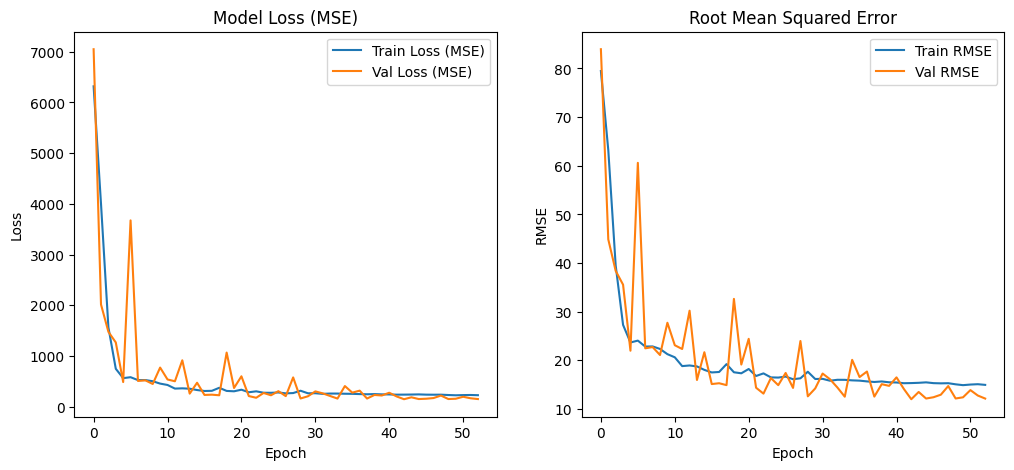

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.show()

In [ ]:
# 1. Load the Test Data
test_df = pd.read_csv('data/test_FD001.txt', sep=r'\s+', header=None, names=col_names)

# 2. Scale the Test Data (CRITICAL: Use the SAME scaler from Task 1.4)
# We use transform(), NOT fit_transform()
test_df[sequence_cols] = scaler.transform(test_df[sequence_cols])

# 3. Generate the Last Sequence for each engine
# In the test set, we want to predict the RUL at the VERY LAST cycle provided
X_test = []

for unit in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit]

    # Check if the engine has at least 50 cycles of datab
    if len(unit_data) >= 50:
        # Get the last 50 rows
        last_seq = unit_data[sequence_cols].values[-50:]
        X_test.append(last_seq)
    else:
        # This shouldn't happen in FD001, but it's good defensive coding:
        # Pad with zeros if the engine is too "young"
        padding = np.zeros((50 - len(unit_data), len(sequence_cols)))
        last_seq = np.vstack((padding, unit_data[sequence_cols].values))
        X_test.append(last_seq)

X_test = np.asarray(X_test).astype(np.float32)

print(f"X_test reshaped to: {X_test.shape}") # Should be (100, 50, 14)

X_test reshaped to: (100, 50, 14)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


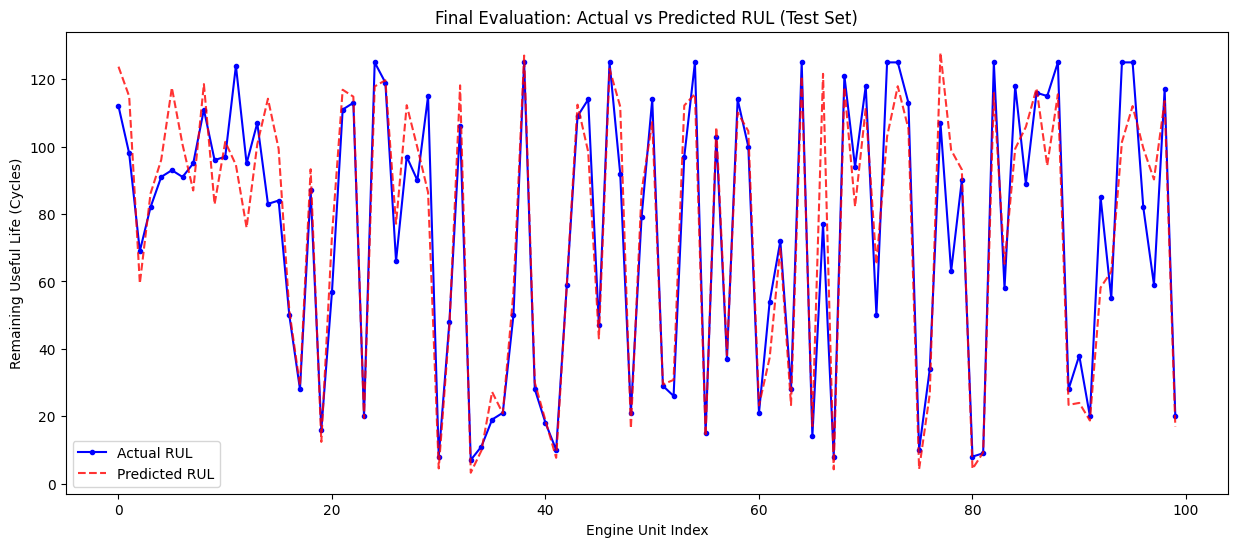

Final Test MAE: 9.38


In [ ]:
# 1. Load Ground Truth RUL for Test Set
y_true = pd.read_csv('data/RUL_FD001.txt', sep=r'\s+', header=None).values.flatten()
y_true = np.clip(y_true, 0, 125) # Clip the ground truth to match our training style

# 2. Predict on X_test (from the code we prepared earlier)
y_pred = model.predict(X_test).flatten()

# 3. Visualize Prediction vs Actual
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Actual RUL', color='blue', marker='o', markersize=3)
plt.plot(y_pred, label='Predicted RUL', color='red', linestyle='--', alpha=0.8)
plt.title('Final Evaluation: Actual vs Predicted RUL (Test Set)')
plt.xlabel('Engine Unit Index')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error
print(f"Final Test MAE: {mean_absolute_error(y_true, y_pred):.2f}")

In [ ]:
# 2.6
import json

# 1. Save the Model (H5 or Keras format)
model.save('artifacts/lstm_model_v1.keras')

# 2. Save the Scaler (Already done in 1.4, but let's be sure)
joblib.dump(scaler, 'artifacts/scaler.pkl')

# 3. Save the Feature Names (The 14 sensors)
# This ensures our API knows exactly which columns to expect and in what order
pipeline_metadata = {
    "features": sequence_cols,
    "sequence_length": 50,
    "mae_score": 9.38,
    "clipping_value": 125
}

with open('artifacts/metadata.json', 'w') as f:
    json.dump(pipeline_metadata, f)

print("Task 2.6: All artifacts saved in /artifacts folder.")

Task 2.6: All artifacts saved in /artifacts folder.


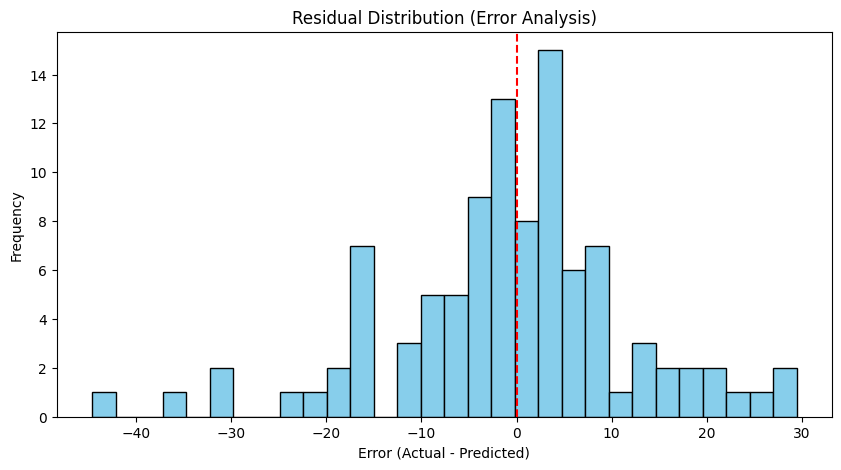

In [ ]:
residuals = y_true - y_pred

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title('Residual Distribution (Error Analysis)')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Generate a requirements file for deployment
!pip freeze > requirements.txt
print("requirements.txt generated.")

requirements.txt generated.
